# TP de cryptographie – Notebook

Ce notebook reprend les exercices du TP :
- Chiffrement par flot (XOR)
- Chiffrement symétrique avec AES (ECB, OFB, CBC)
- Application de chiffrement/déchiffrement de fichiers
- RSA avec PyCryptodome
- Petite implémentation "maison" de RSA
- Signatures numériques
- Échange de clés Diffie–Hellman + utilisation avec AES


In [2]:
from Crypto.Util.strxor import strxor
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
from Crypto.PublicKey import RSA
from Crypto.Hash import SHA256
from Crypto.Signature import pkcs1_15

import hashlib
import os
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

## Chiffrement par flot (XOR)

In [5]:
def xor_bytes(message: bytes, key: bytes) -> bytes:
    """
    Chiffre/déchiffre un message avec XOR et une clé répétée.
    """
    full_key = (key * (len(message) // len(key) + 1))[:len(message)]
    return strxor(message, full_key)


def xor_text(message_str: str, key_str: str) -> bytes:
    """
    Chiffre un texte (str) avec XOR et renvoie les octets chiffrés.
    """
    m = message_str.encode()
    k = key_str.encode()
    return xor_bytes(m, k)


def xor_text_decrypt(ciphertext: bytes, key_str: str) -> str:
    """
    Déchiffre des octets chiffrés avec XOR et renvoie une str.
    """
    k = key_str.encode()
    plain_bytes = xor_bytes(ciphertext, k)
    return plain_bytes.decode()


#### Exemples

In [6]:
m = b"ASTRE"
k = b"ENSIM"

c = xor_bytes(m, k)
print(m, "xor", k, "=", c)

s = xor_bytes(c, k)
print(c, "xor", k, "=", s)


b'ASTRE' xor b'ENSIM' = b'\x04\x1d\x07\x1b\x08'
b'\x04\x1d\x07\x1b\x08' xor b'ENSIM' = b'ASTRE'


In [7]:
phrase = "Je suis un ensimien en cinquième année ASTRE et j'adore la cryptographie"
cle = "ENSIM"

# Chiffrement
c = xor_text(phrase, cle)
print("Message chiffré (octets) :")
print(c)

# Déchiffrement
m_recup = xor_text_decrypt(c, cle)
print("\nMessage déchiffré :")
print(m_recup)


Message chiffré (octets) :
b'\x0f+s:8,=s<#e+=:$(\'6\'m  s*$+?& \x8e\xed#6i,+ \x90\xe0(e\x0f\x00\x1d\x1f\x00n6=m/i2-"7+s%,e-!0=1!4;,5&:,'

Message déchiffré :
Je suis un ensimien en cinquième année ASTRE et j'adore la cryptographie


In [8]:
c_list = [
    1, 51, 42, 51, 44, 109, 107, 51, 44, 52, 56, 101, 48, 32, 61, 32, 57, 97,
    62, 49, 42, 45, 34, 54, 38, 51, 107, 41, 38, 97, 40, 45, 42, 39, 45, 55,
    38, 44, 46, 43, 55, 97, 59, 36, 49, 97, 51, 42, 49, 97, 46, 43, 99, 17,
    50, 49, 43, 46, 37, 101, 98
]

cipher_bytes = bytes(c_list)
key = "CAKE"

plain = xor_bytes(cipher_bytes, key.encode())
print("Message décodé :")
print(plain.decode())


Message décodé :
Bravo, vous savez utiliser le chiffrement par xor en Python !


### Utilisation de l’AES

In [9]:
def aes_encrypt(message: bytes, key: bytes, mode_name: str = "CBC"):
    """
    Chiffre un message (bytes) avec AES + padding PKCS#7.
    Retourne (ciphertext, iv, mode_used)
    """
    mode_name = mode_name.upper()

    if mode_name == "ECB":
        cipher = AES.new(key, AES.MODE_ECB)
        iv = None
    elif mode_name == "CBC":
        cipher = AES.new(key, AES.MODE_CBC)
        iv = cipher.iv
    elif mode_name == "OFB":
        cipher = AES.new(key, AES.MODE_OFB)
        iv = cipher.iv
    else:
        raise ValueError("Mode non supporté (utiliser: ECB, CBC, OFB)")

    padded = pad(message, AES.block_size)
    c = cipher.encrypt(padded)
    return c, iv, mode_name


def aes_decrypt(ciphertext: bytes, key: bytes, mode_name: str, iv: bytes = None) -> bytes:
    """
    Déchiffre un message AES selon le mode choisi.
    """
    mode_name = mode_name.upper()

    if mode_name == "ECB":
        cipher = AES.new(key, AES.MODE_ECB)
    elif mode_name == "CBC":
        cipher = AES.new(key, AES.MODE_CBC, iv=iv)
    elif mode_name == "OFB":
        cipher = AES.new(key, AES.MODE_OFB, iv=iv)
    else:
        raise ValueError("Mode non supporté (utiliser: ECB, CBC, OFB)")

    padded = cipher.decrypt(ciphertext)
    message = unpad(padded, AES.block_size)
    return message


In [10]:
message = b"Bonjour Hello World!."
key = get_random_bytes(32)  # clé 256 bits

for mode in ["ECB", "CBC", "OFB"]:
    print(f"\n=== Mode {mode} ===")
    c, iv, used_mode = aes_encrypt(message, key, mode)
    print("Ciphertext (hex) :", c.hex()[:64], "...")
    m_decrypted = aes_decrypt(c, key, used_mode, iv)
    print("Dechiffre        :", m_decrypted)



=== Mode ECB ===
Ciphertext (hex) : f718e5c83fd37a987119bbc675a12e242e769329491a2fef7a0dc75f5e07c2d5 ...
Dechiffre        : b'Bonjour Hello World!.'

=== Mode CBC ===
Ciphertext (hex) : 1fae591e1b815919939a20ab794cc06e8cd80d0c75a6d2053026ba9f6bce3c08 ...
Dechiffre        : b'Bonjour Hello World!.'

=== Mode OFB ===
Ciphertext (hex) : 8ff44a088d6c6f40739e8ae04eab795b958135cc9692b3195c847bd0411780eb ...
Dechiffre        : b'Bonjour Hello World!.'


In [23]:
def aes_encrypt_file(input_path: str, output_path: str, key: bytes, mode_name: str = "CBC"):
    """
    Chiffre un fichier binaire (image, audio, texte...) avec AES.
    """
    mode_name = mode_name.upper()

    with open(input_path, "rb") as f:
        data = f.read()

    c, iv, mode_used = aes_encrypt(data, key, mode_name)

    # On stocke : mode | iv_length | iv | ciphertext
    with open(output_path, "wb") as f:
        f.write(mode_used.encode("ascii") + b"|")
        iv_bytes = iv if iv is not None else b""
        f.write(len(iv_bytes).to_bytes(1, "big"))
        f.write(iv_bytes)
        f.write(c)


def aes_decrypt_file(input_path: str, output_path: str, key: bytes):
    """
    Déchiffre un fichier binaire chiffré par aes_encrypt_file.
    """
    with open(input_path, "rb") as f:
        header = b""
        while True:
            ch = f.read(1)
            if ch == b"|":
                break
            header += ch
        mode_name = header.decode("ascii")
        iv_len = int.from_bytes(f.read(1), "big")
        iv = f.read(iv_len) if iv_len > 0 else None
        c = f.read()

    data = aes_decrypt(c, key, mode_name, iv)
    with open(output_path, "wb") as f:
        f.write(data)


def show_encrypted_image(bin_path: str, original_image_path: str):
    # 1) On lit le fichier .bin et on récupère juste le ciphertext
    with open(bin_path, "rb") as f:
        header = b""
        while True:
            ch = f.read(1)
            if ch == b"|":
                break
            header += ch
        mode_name = header.decode("ascii")
        iv_len = int.from_bytes(f.read(1), "big")
        iv = f.read(iv_len) if iv_len > 0 else None
        ciphertext = f.read()

    print("Mode de chiffrement stocké dans le fichier :", mode_name)

    # 2) On récupère la taille de l'image originale
    img_orig = Image.open(original_image_path).convert("L")  # L = niveaux de gris
    w, h = img_orig.size
    print("Taille image originale :", w, "x", h)

    # 3) On adapte la longueur des données chiffrées à w*h
    needed = w * h
    data = ciphertext
    if len(data) < needed:
        # on complète avec des 0 si pas assez de bytes
        data = data + b"\x00" * (needed - len(data))
    else:
        # on tronque si trop long
        data = data[:needed]

    # 4) On construit une image à partir des bytes chiffrés
    img_enc = Image.frombytes("L", (w, h), data)

    # 5) Affichage
    plt.figure(figsize=(8, 8))
    plt.title("Image chiffrée")
    plt.imshow(img_enc)
    plt.axis("off")
    plt.show()



Mode de chiffrement stocké dans le fichier : ECB
Taille image originale : 974 x 250


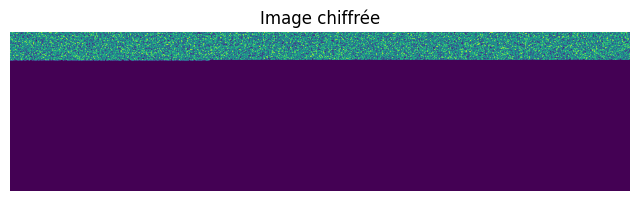

Fichier chiffré et déchiffré. Compare image.png et image_decrypted.png.


In [26]:
key_files = get_random_bytes(32)

# Chiffrer
aes_encrypt_file("image.png", "image_encrypted.bin", key_files, "ECB")

# Afficher l'image chiffrée
show_encrypted_image("image_encrypted.bin", "image.png")

# Déchiffrer
aes_decrypt_file("image_encrypted.bin", "image_decrypted.png", key_files)

print("Fichier chiffré et déchiffré. Compare image.png et image_decrypted.png.")


### Application de chiffrement et déchiffrement 

#### Application de chiffrement/déchiffrement AES ===> app_aes.py
Tapez E pour chiffrer, D pour déchiffrer : E

Chemin du fichier à traiter : image.png

Mot de passe (clé de chiffrement) : ****

Mode AES (ECB, CBC, OFB) [CBC par défaut] : CBC

Fichier chiffré en CBC -> image.png.enc


### RSA

In [38]:
# Génération d'une paire de clés RSA 2048 bits
key_rsa = RSA.generate(2048)
private_key = key_rsa
public_key = key_rsa.publickey()

print("Taille du module n :", private_key.n.bit_length(), "bits")
print(" Public Key :", public_key.export_key().decode())

# Chiffrement / déchiffrement d'un message court avec RSA-OAEP

message = "Message secret via RSA"
m_bytes = message.encode()

cipher_rsa = PKCS1_OAEP.new(public_key)
c_rsa = cipher_rsa.encrypt(m_bytes)
print("Cipher RSA (hex, début) :", c_rsa.hex()[:80], "...")

dec_rsa = PKCS1_OAEP.new(private_key)
m_rec = dec_rsa.decrypt(c_rsa)
print("Message déchiffré       :", m_rec.decode())


Taille du module n : 2048 bits
 Public Key : -----BEGIN PUBLIC KEY-----
MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAqjE8Uzn489xgpc6loDRL
fGJJfN2czCoCPQ9nRxw0xUaNKd865iwCrWMGWB3WLl+ZodrUZHVCXqZ3IkuDq4uO
gCcllMRA/c45yIDGJCW8Y6LJb/vLcurwHik4WwURElT0SpuhXPrri7RCufSJAgUe
k90LT25BUd++QYgXg2aKbKTA2qCrHrYATrTo1trptO4R/AM94GTteRZD4QOG0VzS
pVVJzXrw1q13Hjy/ayd1OWAllp4NJ7rD7DyyhK/ZYYTWz6eWHrWJGAXE5C8fc4Mr
1ntwtaxP+1AKbgfnGZ5m2SbrFaJ1GtbILKp37NE6P/Lqnr/E5MshPMz0YKVaEsJM
ewIDAQAB
-----END PUBLIC KEY-----
Cipher RSA (hex, début) : 1c385d9ad0391c720ed07feb768d7a736018ee2570d2ed28eedf6c70073477cfcd7d6dfbdac9e9ea ...
Message déchiffré       : Message secret via RSA


In [39]:
def hybrid_encrypt(plaintext: bytes, public_key: RSA.RsaKey):
    """
    Chiffre un message avec :
      - AES-CBC (symétrique) pour le contenu
      - RSA-OAEP pour chiffrer la clé AES
    Retourne (clé_AES_chiffrée, iv, ciphertext_AES)
    """
    # Clé AES aléatoire 256 bits
    aes_key = get_random_bytes(32)

    # Chiffrement AES-CBC du message
    c_aes, iv, _ = aes_encrypt(plaintext, aes_key, "CBC")

    # Chiffrement de la clé AES avec RSA
    cipher_rsa = PKCS1_OAEP.new(public_key)
    enc_key = cipher_rsa.encrypt(aes_key)

    return enc_key, iv, c_aes


def hybrid_decrypt(enc_key: bytes, iv: bytes, c_aes: bytes, private_key: RSA.RsaKey) -> bytes:
    """
    Déchiffre (clé_AES_chiffrée, iv, ciphertext_AES) en utilisant la clé privée RSA.
    """
    # Déchiffrer la clé AES
    dec_rsa = PKCS1_OAEP.new(private_key)
    aes_key = dec_rsa.decrypt(enc_key)

    # Déchiffrer le message avec AES-CBC
    plaintext = aes_decrypt(c_aes, aes_key, "CBC", iv)
    return plaintext


In [43]:
msg = b"Super secret message combine AES-CBC et RSA pour la cle."

# Alice chiffre pour Bob (en utilisant la clé publique de Bob)
enc_key, iv, c_aes = hybrid_encrypt(msg, public_key)

# Bob déchiffre (clé privée de Bob)
msg_rec = hybrid_decrypt(enc_key, iv, c_aes, private_key)

print("Message original :", msg)
print("Message reçu     :", msg_rec)
print("Identiques ?     :", msg == msg_rec)


Message original : b'Super secret message combine AES-CBC et RSA pour la cle.'
Message reçu     : b'Super secret message combine AES-CBC et RSA pour la cle.'
Identiques ?     : True


### Generation petite clé RSA

In [8]:
import random
from math import gcd

def extended_gcd(a, b):
    """
    Algorithme d'Euclide étendu.
    Retourne (g, x, y) tel que g = gcd(a,b) et ax + by = g.
    """
    if b == 0:
        return a, 1, 0
    g, x1, y1 = extended_gcd(b, a % b)
    x = y1
    y = x1 - (a // b) * y1
    return g, x, y


def modinv(a, n):
    """
    Inverse mod n de a (a*d ≡ 1 (mod n)).
    """
    g, x, _ = extended_gcd(a, n)
    if g != 1:
        raise ValueError("Pas d'inverse modulaire pour a modulo n")
    return x % n


def is_prime(n):
    """
    Test de primalité simple par division (OK pour des petits nombres).
    """
    if n < 2:
        return False
    if n % 2 == 0:
        return n == 2
    p = 3
    while p * p <= n:
        if n % p == 0:
            return False
        p += 2
    return True


def generate_prime(bits=8):
    """
    Génère un petit nombre premier de 'bits' bits.
    """
    while True:
        n = random.randrange(2**(bits-1), 2**bits)
        if n % 2 == 0:
            n += 1
        if is_prime(n):
            return n


In [9]:
def small_rsa_keygen(bits=8):
    """
    Génère une petite clé RSA pour la démo (p et q ~ 8 bits -> n ~ 16 bits).
    """
    p = generate_prime(bits)
    q = generate_prime(bits)
    while q == p:
        q = generate_prime(bits)

    n = p * q
    phi = (p - 1) * (q - 1)

    # Choix d'un exposant public e
    e = 65537
    if gcd(e, phi) != 1:
        e = 3
        while gcd(e, phi) != 1:
            e += 2

    d = modinv(e, phi)
    return (n, e, d, p, q)


def rsa_encrypt_int(m, n, e):
    return pow(m, e, n)


def rsa_decrypt_int(c, n, d):
    return pow(c, d, n)

def rsa_encrypt_value(value, n, e):
    """
    Chiffre value qui peut être :
      - un int  -> on le chiffre directement
      - une str -> on la encode(), puis int.from_bytes(...)
    Retourne (cipher_int, value_type, length_bytes)
    """
    if isinstance(value, int):
        m_int = value
        value_type = "int"
        length = None
    elif isinstance(value, str):
        data = value.encode()
        m_int = int.from_bytes(data, "big")
        value_type = "str"
        length = len(data)
    else:
        raise TypeError("value doit être un int ou une str")

    if m_int >= n:
        raise ValueError(f"Valeur trop grande pour ce n={n}. Utilise un message plus court ou un n plus grand.")

    c_int = rsa_encrypt_int(m_int, n, e)
    return c_int, value_type, length


def rsa_decrypt_value(c_int, n, d, value_type, length=None):
    """
    Déchiffre c_int (int) et reconstruit :
      - un int si value_type == 'int'
      - une str si value_type == 'str' (en utilisant length)
    """
    m_int = rsa_decrypt_int(c_int, n, d)

    if value_type == "int":
        return m_int

    elif value_type == "str":
        if length is None:
            # secours : calculer une longueur minimale
            length = (m_int.bit_length() + 7) // 8
        data = m_int.to_bytes(length, "big")
        return data.decode()

    else:
        raise ValueError("value_type doit être 'int' ou 'str'")



# Génération de petites clés
n_small, e_small, d_small, p_small, q_small = small_rsa_keygen(bits=8)
print(f"p={p_small}, q={q_small}, n={n_small}, e={e_small}, d={d_small}")

# Exemple avec un entier
m_int = 42
c_int = rsa_encrypt_int(m_int, n_small, e_small)
m_rec_int = rsa_decrypt_int(c_int, n_small, d_small)

print("m    =", m_int)
print("c    =", c_int)
print("m'   =", m_rec_int)


p=239, q=139, n=33221, e=65537, d=11093
m    = 42
c    = 16776
m'   = 42


In [10]:
msg = "OK"
c_int, vtype, length = rsa_encrypt_value(msg, n_small, e_small)
msg_rec = rsa_decrypt_value(c_int, n_small, d_small, vtype, length)

print("Message original :", msg)
print("Message reçu     :", msg_rec)


Message original : OK
Message reçu     : OK


In [11]:
def rsa_sign_no_hash(value, n, d):
    """
    Signature RSA 'brute' SANS hachage (pédagogique).
    value peut être :
      - int  : signé directement
      - str  : encodée en bytes, puis convertie en int

    Retourne (signature_int, value_type, length_bytes)
    """
    if isinstance(value, int):
        m_int = value
        value_type = "int"
        length = None
    elif isinstance(value, str):
        data = value.encode()
        m_int = int.from_bytes(data, "big")
        value_type = "str"
        length = len(data)
    else:
        raise TypeError("value doit être un int ou une str")

    if m_int >= n:
        raise ValueError(f"Valeur trop grande pour ce n={n}. Utiliser une valeur plus petite ou un n plus grand.")

    # "Signature" = m^d mod n
    s_int = pow(m_int, d, n)
    return s_int, value_type, length


def rsa_verify_no_hash(s_int, n, e, original_value, value_type, length=None):
    """
    Vérifie une signature RSA 'brute' SANS hachage.
    On recalcule m' = s^e mod n et on compare au message original.
    """
    # récupérer m' à partir de la signature
    m_rec_int = pow(s_int, e, n)

    if value_type == "int":
        # le message attendu est un int
        if not isinstance(original_value, int):
            raise TypeError("original_value doit être un int")
        return m_rec_int == original_value

    elif value_type == "str":
        if not isinstance(original_value, str):
            raise TypeError("original_value doit être une str")
        data_rec = m_rec_int.to_bytes(length, "big")
        msg_rec = data_rec.decode()
        return msg_rec == original_value

    else:
        raise ValueError("value_type doit être 'int' ou 'str'")


In [69]:
msg = 123

s_int, vtype, length = rsa_sign_no_hash(msg, n_small, d_small)
ok = rsa_verify_no_hash(s_int, n_small, e_small, msg, vtype, length)

print("Message        :", msg)
print("Signature int  :", s_int)
print("Signature OK ? :", ok)


Message        : 123
Signature int  : 828
Signature OK ? : True


In [12]:
def rsa_sign_with_hash(message: bytes, private_key: RSA.RsaKey):
    """
    Signature RSA avec hachage SHA-256.
    Principe :
      h = SHA256(message)
      s = h^d mod n
    Retourne signature en tant qu'entier.
    """
    # hachage du message
    h = SHA256.new(message).digest()
    h_int = int.from_bytes(h, "big")

    # signature RSA (math brute)
    d = private_key.d
    n = private_key.n
    s_int = pow(h_int, d, n)
    return s_int


def rsa_verify_with_hash(message: bytes, s_int: int, public_key: RSA.RsaKey):
    """
    Vérifie une signature RSA avec hachage SHA-256.
    On vérifie que :
      (s^e mod n) == SHA256(message)
    """
    # recalcul du haché du message
    h = SHA256.new(message).digest()
    h_int = int.from_bytes(h, "big")

    # récupération du haché signée
    e = public_key.e
    n = public_key.n
    h_rec_int = pow(s_int, e, n)

    return h_rec_int == h_int


In [72]:
key_rsa = RSA.generate(2048)
private_key = key_rsa
public_key = key_rsa.publickey()

print("Taille n (bits) :", private_key.n.bit_length())

msg = b"Message important a signer"

# Signature
s_int = rsa_sign_with_hash(msg, private_key)
print("Signature (int) :", s_int)

# Vérification OK
ok = rsa_verify_with_hash(msg, s_int, public_key)
print("Signature valide sur message original ? :", ok)

# Vérification sur message modifié
msg_mod = b"Message important a signeR"  # on change juste une lettre
ok_mod = rsa_verify_with_hash(msg_mod, s_int, public_key)
print("Signature valide sur message modifie ?  :", ok_mod)


Taille n (bits) : 2048
Signature (int) : 17612206820647726019675383493854748360220219861163913393869145738883987831060742847900690406191531643541715872135884245922667670466048286207553687892406655209617079679484157514050241265302863862432050449473024988003860088678463349264851291643143954682065046091671273252376479821801452940968662638933213454400535611967057621567702203824604495035029650099804552232389038843294276067038374438848231929883705928626419152749321559087844233513040573342090754599944210293848112604927350075909448221110356064464125193116010969375123600818228422941412324860530912190324230207658755507411484061565334582428547172900061681249488
Signature valide sur message original ? : True
Signature valide sur message modifie ?  : False


### Echange de Diffie–Hellman

In [5]:
import random

# Paramètres Diffie–Hellman (exemple pédagogique)
# En pratique on utiliserait un très grand premier, ici on simplifie.
p = 0xFFFFFFFB  # grand premier 32 bits (juste pour le TP)
g = 5           # générateur

print("p =", hex(p))
print("g =", g)

# Secrets privés d'Alice et Bob
a = random.randint(2, p - 2)  # secret Alice
b = random.randint(2, p - 2)  # secret Bob

# Valeurs publiques échangées sur le réseau
A = pow(g, a, p)  # ce qu'Alice envoie
B = pow(g, b, p)  # ce que Bob envoie

print("A (public Alice) =", A)
print("B (public Bob)   =", B)

# Calcul du secret partagé des deux côtés
s_alice = pow(B, a, p)
s_bob   = pow(A, b, p)

print("Secret Alice :", s_alice)
print("Secret Bob   :", s_bob)
print("Egaux ?      :", s_alice == s_bob)

p = 0xfffffffb
g = 5
A (public Alice) = 2521572640
B (public Bob)   = 4087582452
Secret Alice : 855498744
Secret Bob   : 855498744
Egaux ?      : True


In [6]:
def make_aes_key_from_dh(shared_secret: int) -> bytes:
    """
    Transforme le secret DH (entier) en clé AES 256 bits via SHA-256.
    """
    shared_bytes = shared_secret.to_bytes((shared_secret.bit_length() + 7) // 8, "big")
    return hashlib.sha256(shared_bytes).digest()  # 32 octets -> AES-256

dh_key = make_aes_key_from_dh(s_alice)  # ou s_bob: c'est le même
print("Clé AES dérivée (hex, début) :", dh_key.hex()[:64], "...")
len(dh_key)


Clé AES dérivée (hex, début) : e6c5c908a224e45a0599933c147fb8363554409c0c516353188c624d6b0d1c87 ...


32

In [14]:
import app_aes
from app_aes import aes_encrypt, aes_decrypt, aes_encrypt_file, aes_decrypt_file

# Message à chiffrer avec la clé issue de Diffie–Hellman
msg_dh = b"Message secret protege par Diffie-Hellman + AES-CBC"

# Chiffrement côté "Alice"
c_dh, iv_dh, _ = aes_encrypt(msg_dh, dh_key, "CBC")

print("Ciphertext (hex, début) :", c_dh.hex()[:80], "...")
print("IV (hex)                 :", iv_dh.hex())

# Dechiffrement côté "Bob" avec la même clé dh_key
msg_rec_dh = aes_decrypt(c_dh, dh_key, "CBC", iv_dh)

print("Message original :", msg_dh)
print("Message recu     :", msg_rec_dh)
print("Identiques ?     :", msg_dh == msg_rec_dh)


Ciphertext (hex, début) : b9eadaf3ef5849a1750bcd65181431a528225b7e21ec330b0162a37466b1f330350c976043fd0f22 ...
IV (hex)                 : 13f5cb298db494579a1a9354e69c1838
Message original : b'Message secret protege par Diffie-Hellman + AES-CBC'
Message recu     : b'Message secret protege par Diffie-Hellman + AES-CBC'
Identiques ?     : True


In [15]:
msg_dh = b"Message secret protege par Diffie-Hellman + AES-CBC (app_aes)"

# Chiffrement avec AES-CBC de app_aes
c_dh, iv_dh, _ = aes_encrypt(msg_dh, dh_key, "CBC")

print("Ciphertext (hex, début) :", c_dh.hex()[:80], "...")
print("IV (hex)                 :", iv_dh.hex())

# Dechiffrement avec AES-CBC de app_aes
msg_rec_dh = aes_decrypt(c_dh, dh_key, "CBC", iv_dh)

print("Message original :", msg_dh)
print("Message recu     :", msg_rec_dh)
print("Identiques ?     :", msg_dh == msg_rec_dh)


Ciphertext (hex, début) : dcf2510e76d9657389f4d6ff3461a0f6a961770c43280bda299521f1ce85a955b645af23fb4dee41 ...
IV (hex)                 : c5f4d9bf79d86d79b0eedb416087e6d5
Message original : b'Message secret protege par Diffie-Hellman + AES-CBC (app_aes)'
Message recu     : b'Message secret protege par Diffie-Hellman + AES-CBC (app_aes)'
Identiques ?     : True


In [16]:
def encrypt_file_with_dh_key(input_path: str, output_path: str, shared_secret: int, mode_name: str = "CBC"):
    key = make_aes_key_from_dh(shared_secret)
    aes_encrypt_file(input_path, output_path, key, mode_name)

def decrypt_file_with_dh_key(input_path: str, output_path: str, shared_secret: int):
    key = make_aes_key_from_dh(shared_secret)
    aes_decrypt_file(input_path, output_path, key)


# Exemple avec un fichier (audio, image, texte...)
f_in  = "00b01445_nohash_0.wav"
f_enc = "00b01445_nohash_0_dh.enc"
f_dec = "00b01445_nohash_0_dh_dec.wav"

# Côté Alice (chiffrement)
encrypt_file_with_dh_key(f_in, f_enc, s_alice, mode_name="CBC")
print("Fichier chiffré ->", f_enc)

# Côté Bob (déchiffrement)
decrypt_file_with_dh_key(f_enc, f_dec, s_bob)
print("Fichier déchiffré ->", f_dec)


Fichier chiffré -> 00b01445_nohash_0_dh.enc
Fichier déchiffré -> 00b01445_nohash_0_dh_dec.wav


### Simulation d’une blockchain simplifiée

In [1]:
import hashlib
import time
from dataclasses import dataclass, field
from typing import Any, List


#### Classe Block

In [2]:
@dataclass
class Block:
    index: int
    timestamp: float
    data: Any
    previous_hash: str
    nonce: int = 0
    hash: str = field(default="", init=False)

    def compute_hash(self) -> str:
        """
        Calcule le hash SHA-256 du bloc actuel.
        """
        block_string = f"{self.index}{self.timestamp}{self.data}{self.previous_hash}{self.nonce}"
        return hashlib.sha256(block_string.encode()).hexdigest()


#### Fonction de preuve de travail

In [3]:
def proof_of_work(block: Block, difficulty: int = 3) -> str:
    """
    Trouve un nonce tel que le hash du bloc commence par 'difficulty' zéros.
    Modifie block.nonce jusqu'à ce que la condition soit satisfaite.
    Retourne le hash valide.
    """
    prefix = "0" * difficulty

    while True:
        h = block.compute_hash()
        if h.startswith(prefix):
            return h
        block.nonce += 1


#### Classe Blockchain

In [4]:
class Blockchain:
    def __init__(self, difficulty: int = 3):
        self.difficulty = difficulty
        self.chain: List[Block] = []
        self.create_genesis_block()

    def create_genesis_block(self):
        """
        Crée le bloc de genèse (premier bloc de la chaîne).
        """
        genesis_block = Block(
            index=0,
            timestamp=time.time(),
            data="Bloc de genèse",
            previous_hash="0" * 64  # pas de bloc précédent
        )
        genesis_block.hash = proof_of_work(genesis_block, self.difficulty)
        self.chain.append(genesis_block)

    @property
    def last_block(self) -> Block:
        return self.chain[-1]

    def add_block(self, data: Any):
        """
        Crée un nouveau bloc avec 'data', le mine et l'ajoute à la chaîne.
        """
        new_block = Block(
            index=len(self.chain),
            timestamp=time.time(),
            data=data,
            previous_hash=self.last_block.hash
        )
        new_block.hash = proof_of_work(new_block, self.difficulty)
        self.chain.append(new_block)

    def is_valid(self) -> bool:
        """
        Vérifie l'intégrité de la blockchain :
          - chaque previous_hash correspond au hash du bloc précédent
          - le hash de chaque bloc est correct et respecte la difficulté
        """
        prefix = "0" * self.difficulty

        for i in range(1, len(self.chain)):
            prev = self.chain[i - 1]
            curr = self.chain[i]

            # Vérifier le lien entre les blocs
            if curr.previous_hash != prev.hash:
                print(f"Erreur de lien entre les blocs {i-1} et {i}")
                return False

            # Vérifier que le hash est correct
            if curr.hash != curr.compute_hash():
                print(f"Hash invalide pour le bloc {i}")
                return False

            # Vérifier la difficulté
            if not curr.hash.startswith(prefix):
                print(f"Preuve de travail invalide pour le bloc {i}")
                return False

        return True


#### Test de la blockchain : ajout de blocs

In [5]:
# Création d'une blockchain avec difficulté 3 (hash commence par "000")
my_chain = Blockchain(difficulty=3)

# Ajout de quelques blocs
my_chain.add_block("Transaction 1: Alice -> Bob : 10 ENSIMCoins")
my_chain.add_block("Transaction 2: Bob -> Charlie : 5 ENSIMCoins")
my_chain.add_block({"from": "Charlie", "to": "Alice", "amount": 2})

# Affichage simplifié
for block in my_chain.chain:
    print(f"Bloc {block.index}")
    print(f"  Timestamp     : {time.ctime(block.timestamp)}")
    print(f"  Données       : {block.data}")
    print(f"  Previous_hash : {block.previous_hash[:16]}...")
    print(f"  Hash          : {block.hash[:16]}...")
    print(f"  Nonce         : {block.nonce}")
    print("-" * 60)

print("Blockchain valide ? ", my_chain.is_valid())


Bloc 0
  Timestamp     : Thu Jan 29 10:14:21 2026
  Données       : Bloc de genèse
  Previous_hash : 0000000000000000...
  Hash          : 0008ec62abeb4da3...
  Nonce         : 2935
------------------------------------------------------------
Bloc 1
  Timestamp     : Thu Jan 29 10:14:21 2026
  Données       : Transaction 1: Alice -> Bob : 10 ENSIMCoins
  Previous_hash : 0008ec62abeb4da3...
  Hash          : 000c77054cbea789...
  Nonce         : 6077
------------------------------------------------------------
Bloc 2
  Timestamp     : Thu Jan 29 10:14:21 2026
  Données       : Transaction 2: Bob -> Charlie : 5 ENSIMCoins
  Previous_hash : 000c77054cbea789...
  Hash          : 0004a0b713d55fc3...
  Nonce         : 485
------------------------------------------------------------
Bloc 3
  Timestamp     : Thu Jan 29 10:14:21 2026
  Données       : {'from': 'Charlie', 'to': 'Alice', 'amount': 2}
  Previous_hash : 0004a0b713d55fc3...
  Hash          : 0006640ac9ee3248...
  Nonce         : 374

In [6]:
# Tentative de triche : modifier les données d'un bloc existant
print("Avant modification, chaîne valide ? :", my_chain.is_valid())

# On modifie les données du bloc 1
my_chain.chain[1].data = "Transaction TRUQUEE: Alice -> Bob : 1000 ENSIMCoins"

print("Après modification, chaîne valide ? :", my_chain.is_valid())


Avant modification, chaîne valide ? : True
Hash invalide pour le bloc 1
Après modification, chaîne valide ? : False
